In [1]:
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
load_dotenv()


host = os.environ.get('HOST')
port = os.environ.get('PORT')
database = os.environ.get('DATABASE')
username = os.environ.get('USER')
password = os.environ.get('PASSWORD')

In [2]:
customers = pd.read_excel('data/coffee_data.xlsx', sheet_name='customers')
customers.head()

,Customer ID,Customer Name,Email,Phone Number,Address Line 1,City,Country,Postcode,Loyalty Card
0,17670-51384-MA,Aloisia Allner,aallner0@lulu.com,+1 (862) 817-0124,57999 Pepper Wood Alley,Paterson,United States,7505,Yes
1,73342-18763-UW,Piotr Bote,pbote1@yelp.com,+353 (913) 396-4653,2112 Ridgeway Hill,Crumlin,Ireland,D6W,No
2,21125-22134-PX,Jami Redholes,jredholes2@tmall.com,+1 (210) 986-6806,5214 Bartillon Park,San Antonio,United States,78205,Yes
3,71253-00052-RN,Dene Azema,dazema3@facebook.com,+1 (217) 418-0714,27 Maywood Place,Springfield,United States,62711,Yes
4,23806-46781-OU,Christoffer O' Shea,NaN,+353 (698) 362-9201,38980 Manitowish Junction,Cill Airne,Ireland,N41,No


In [3]:
db_url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(db_url)

for i, table in enumerate(['customers', 'orders', 'products']):
    df = pd.read_excel(f'data/coffee_data.xlsx', sheet_name=table)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.to_sql(table, engine, if_exists='replace', index=False)

engine.dispose()

In [4]:
spark = SparkSession.builder \
    .appName("Read from PostgreSQL") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .config("spark.driver.extraClassPath", "postgresql-42.6.0.jar") \
    .getOrCreate()

In [5]:
for table_name in ['customers', 'orders', 'products']:
    big_table_df = spark.read \
        .format("jdbc") \
        .option("driver", "org.postgresql.Driver") \
        .option("url", "jdbc:postgresql://localhost:5432/coffee") \
        .option("dbtable", table_name) \
        .option("user", os.environ.get("USER")) \
        .option("password", os.environ.get("PASSWORD")) \
        .load()
    
    big_table_df.createOrReplaceTempView(table_name)

In [6]:
all_data = spark.sql("""
    select
        *
    from orders o
    join customers c
        on o.customer_id = c.customer_id
    join products p
        on o.product_id = p.product_id
""")

all_data.createOrReplaceTempView('all_data')
all_data.toPandas().columns

Index(['order_id', 'order_date', 'customer_id', 'product_id', 'quantity',
       'customer_id', 'customer_name', 'email', 'phone_number',
       'address_line_1', 'city', 'country', 'postcode', 'loyalty_card',
       'product_id', 'coffee_type', 'roast_type', 'size', 'unit_price',
       'price_per_100g', 'profit'],
      dtype='object')

In [7]:
profit_data = spark.sql(
"""
select
	o.order_id,
	extract (year from o.order_date) as order_year,
	extract (month from o.order_date) as order_month,
	extract (day from o.order_date) as order_day,
	pc.coffee_type,
	pc.roast_type,
	pc.size,
	pc.unit_price,
	pc.profit,
	o.quantity,
	o.quantity * pc.unit_price as total_price,
	o.quantity * pc.profit as total_profit
from orders o
join (
	select
		p.product_id,
		p.coffee_type,
		p.roast_type,
		p.size,
		p.unit_price,
		p.profit
	from products as p
) as pc
	on o.product_id = pc.product_id 
""")

profit_data.createOrReplaceTempView('profit_data')
profit_data.show()

+-------------+----------+-----------+---------+-----------+----------+----+----------+-------+--------+-----------+------------+
|     order_id|order_year|order_month|order_day|coffee_type|roast_type|size|unit_price| profit|quantity|total_price|total_profit|
+-------------+----------+-----------+---------+-----------+----------+----+----------+-------+--------+-----------+------------+
|SNZ-65340-705|      2022|          5|       20|        Lib|         L| 0.2|     4.755|0.61815|       1|      4.755|     0.61815|
|SCT-60553-454|      2021|          7|       17|        Lib|         L| 0.2|     4.755|0.61815|       5|     23.775|     3.09075|
|EEJ-16185-108|      2019|          2|        9|        Lib|         L| 0.2|     4.755|0.61815|       5|     23.775|     3.09075|
|ANM-16388-634|      2021|         11|       19|        Lib|         L| 0.2|     4.755|0.61815|       2|       9.51|      1.2363|
|GAZ-58626-277|      2021|          1|        4|        Lib|         L| 0.2|     4.755|0.6

In [8]:
date_profit_data = spark.sql(
"""
    select
        order_year,
        order_month,
        round (sum(total_price), 2) as price,
        round (sum(total_profit), 2) as profit
    from profit_data
    group by order_year, order_month
    order by order_year desc, order_month desc
""")
date_profit_data.show()
date_profit_df = date_profit_data.toPandas()

+----------+-----------+-------+------+
|order_year|order_month|  price|profit|
+----------+-----------+-------+------+
|      2022|          8| 244.24|  21.3|
|      2022|          7| 906.73| 93.13|
|      2022|          6|1155.39|107.93|
|      2022|          5|1002.37| 97.02|
|      2022|          4| 776.45| 73.21|
|      2022|          3| 1315.2|128.39|
|      2022|          2| 393.63| 40.14|
|      2022|          1|1269.42|146.92|
|      2021|         12|1147.98|115.45|
|      2021|         11|1616.18| 172.6|
|      2021|         10| 1400.4|146.94|
|      2021|          9|1643.58|156.33|
|      2021|          8|1075.91|  96.4|
|      2021|          7| 763.11| 73.01|
|      2021|          6| 864.53| 86.27|
|      2021|          5| 907.69| 86.86|
|      2021|          4|1005.59|114.35|
|      2021|          3|1544.64|156.99|
|      2021|          2| 958.83| 99.64|
|      2021|          1| 837.69| 84.56|
+----------+-----------+-------+------+
only showing top 20 rows


In [9]:
date_profit_df.head()

,order_year,order_month,price,profit
0,2022,8,244.24,21.30
1,2022,7,906.73,93.13
2,2022,6,1155.39,107.93
3,2022,5,1002.37,97.02
4,2022,4,776.45,73.21


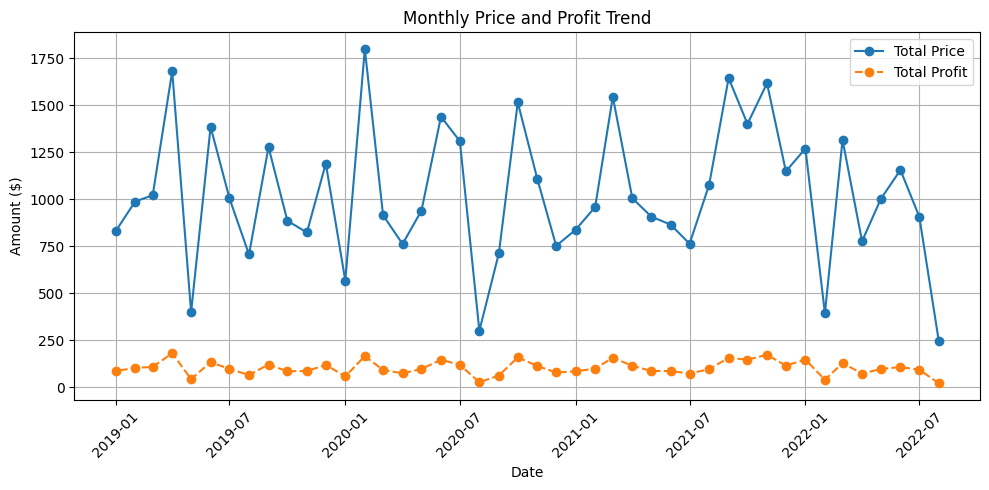

In [10]:
date_profit_df['date'] = pd.to_datetime(date_profit_df['order_year'].astype(str) + '-' + date_profit_df['order_month'].astype(str) + '-01')

plt.figure(figsize=(10, 5))
plt.plot(date_profit_df['date'], date_profit_df['price'], label='Total Price', marker='o')
plt.plot(date_profit_df['date'], date_profit_df['profit'], label='Total Profit', marker='o', linestyle='--')
plt.title('Monthly Price and Profit Trend')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
coffee_type_profit_data = spark.sql(
"""
    select
        coffee_type,
        roast_type,
        -- profit_data.size,
        round (sum(total_price), 2) as price,
        round (sum(total_profit), 2) as profit
    from profit_data
    group by 
        coffee_type,
        roast_type
        -- profit_data.size
"""
)
coffee_type_profit_data.show()
coffee_type_profit_data.createOrReplaceGlobalTempView('coffee_type_profit_data')
coffee_type_profit_df = coffee_type_profit_data.toPandas()

+-----------+----------+-------+------+
|coffee_type|roast_type|  price|profit|
+-----------+----------+-------+------+
|        Rob|         L|3759.47|225.57|
|        Rob|         M|2637.75|158.26|
|        Lib|         D|4096.08|532.49|
|        Ara|         D|3047.69|274.29|
|        Rob|         D|2608.03|156.48|
|        Ara|         M|4488.75|403.99|
|        Exc|         L|4796.55|527.62|
|        Exc|         M|4082.38|449.06|
|        Lib|         L|4566.39|593.63|
|        Exc|         D|3427.51|377.03|
|        Lib|         M|3391.61|440.91|
|        Ara|         L|4232.06|380.89|
+-----------+----------+-------+------+



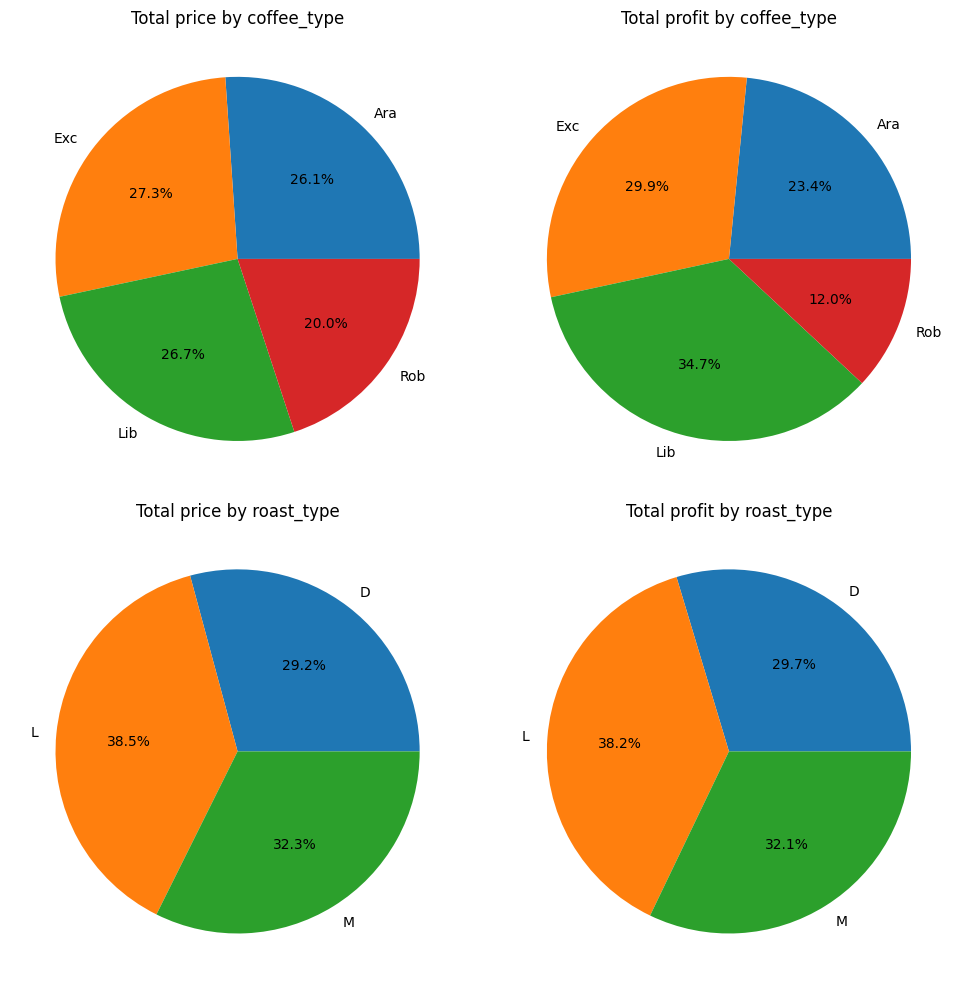

In [12]:
crit_cols = ['coffee_type', 'roast_type']
targ_cols = ['price', 'profit']

plt.figure(figsize=(10, 10))
for x, crit_col in enumerate(crit_cols):
    for y, targ_col in enumerate(targ_cols):
        data = coffee_type_profit_df.groupby(by=crit_col)[targ_col].sum()
        labels = data.index
        plt.subplot(2, 2, x * 2 + y + 1)
        plt.pie(x=data, labels=labels, autopct='%1.1f%%')
        plt.title(f"Total {targ_col} by {crit_col}")
plt.tight_layout()
plt.show()


In [13]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "notebook_connected"

In [14]:
fig = px.sunburst(
    coffee_type_profit_df,
    path=['coffee_type', 'roast_type'],
    values='price',
    color='profit',
    color_continuous_scale='RdBu',
    title='Sunburst: Coffee Type → Roast Type (Size=Price, Color=Profit)',
    hover_data={'price': True, 'profit': True}  
)

fig.show()


In [15]:
fig = px.treemap(
    coffee_type_profit_df,
    path=['coffee_type', 'roast_type'],  
    values='price',                      
    color='profit',                      
    color_continuous_scale='RdBu',
    title='Treemap: Coffee Type → Roast Type (Size = Price, Color = Profit)',
    hover_data={'price': True, 'profit': True}  # show both in hover tooltip
)

fig.show()
